In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import uncrater as uc
from uncrater.utils import cordic2rad, rad2cordic, cordic_add

alpha_to_pdrift = 50e3*4096*16/102.4e6*2*np.pi*1e-6


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import json
def read_adc(ch):
    jdata = json.load(open(f'/u/home/anze/Nov21/adc{ch}_output.json'))
    data = np.array(jdata['data'])
    data[data>8192]-=16384
    return data

ewf = [read_adc(ch+1) for ch in range(4)]

def spec(w):
    return np.abs(np.fft.rfft(w)**2)

In [72]:
C = uc.Collection("session_calibrator/cdi_output", cut_to_hello=True)
C.spectra[0]['meta'].base.actual_gain[:], C.spectra[0]['meta'].adc_min, C.calib_gNacc

Analyzing 298 files from session_calibrator/cdi_output.


([2, 2, 2, 2],
 array([ -22, -259, -317, -287]),
 array([127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127]))

In [73]:
import binascii
weights = np.zeros(512)
weights[299:500] = 1.0
intweights = (weights*255).astype(np.uint32)
#intweights[(intweights == 0xFF)] = 0x100
pweights = [((w2<<16)+w1) for w1,w2 in zip(intweights[0::2],intweights[1::2])]
print ("CRC32 weights: ", hex(binascii.crc32(np.array(pweights,dtype=np.uint32).tobytes())&0xffffffff))


hex(C.cont[1].crc), C.cont[1].weight_ndx

CRC32 weights:  0xdd3fb62


AttributeError: 'Packet_Housekeep' object has no attribute 'crc'

Text(0.5, 0.98, 'PTOPBOT')

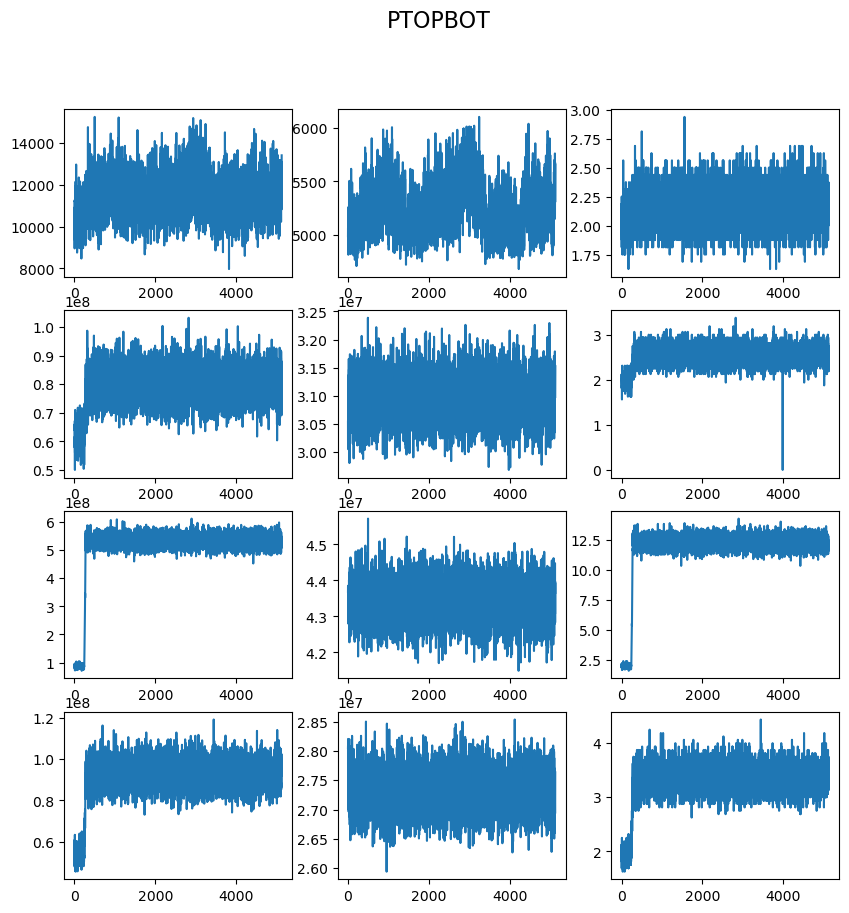

In [74]:
fig, ax = plt.subplots(4,3,figsize=(10,10))
ax[0,0].plot(C.cd_powertop0)
ax[1,0].plot(C.cd_powertop1)
ax[2,0].plot(C.cd_powertop2)
ax[3,0].plot(C.cd_powertop3)

ax[0,1].plot(C.cd_powerbot0)
ax[1,1].plot(C.cd_powerbot1)
ax[2,1].plot(C.cd_powerbot2)
ax[3,1].plot(C.cd_powerbot3)

ax[0,2].plot(C.cd_snr0)
ax[1,2].plot(C.cd_snr1)
ax[2,2].plot(C.cd_snr2)
ax[3,2].plot(C.cd_snr3)
fig.suptitle('PTOPBOT', fontsize=16)

(500.0, 700.0)

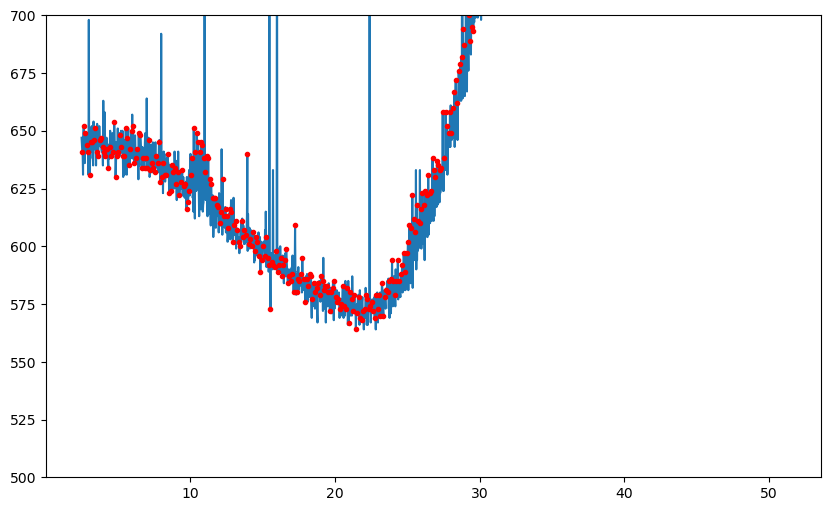

In [75]:
plt.figure(figsize=(10, 6))
freq = C.spectra[2]['meta'].frequency
plt.plot(freq[100:],C.spectra[3][2].data[100:])
plt.plot(freq[102::4],C.spectra[3][2].data[102::4],'r.')
plt.ylim(500,700)

np.float64(2.1225309273798853e-05)

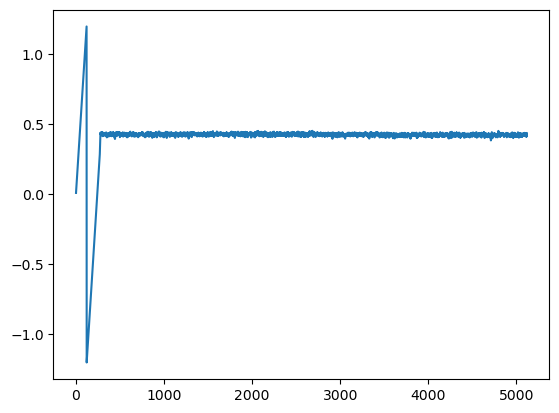

In [76]:

#Cd = uc.Collection("session_calibrator_sd0/cdi_output", cut_to_hello=True)

plt.plot(C.cd_drift[:]/alpha_to_pdrift)
#plt.plot(C.cd_have_lock[:]*0.1,'--')
#plt.plot(np.arange(75), np.arange(75)*0.005)
#plt.plot(C.cd_have_lock[:200]*0.1)
#plt.plot(Cd.cd_drift[:200]/alpha_to_pdrift)
C.cd_drift[200:2000].std()#,Cd.cd_drift[200:2000].std()

[]

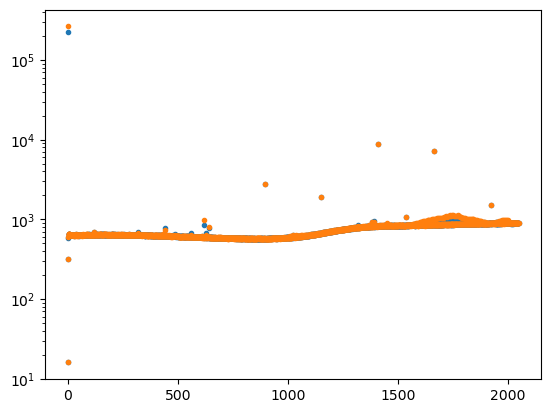

In [77]:
for i in [0,7]:
    plt.plot(np.mean(np.array([sp[2].data[:] for sp in C.spectra[i::8]]),axis=0),'.')
plt.semilogy()

([np.float64(574.0),
  np.float64(566.0),
  np.float64(563.0),
  np.float64(560.0),
  np.float64(559.0),
  np.float64(570.0),
  np.float64(566.0),
  np.float64(570.0),
  np.float64(571.0),
  np.float64(566.0),
  np.float64(569.0),
  np.float64(564.0),
  np.float64(557.0),
  np.float64(560.0),
  np.float64(561.0),
  np.float64(559.0),
  np.float64(562.0),
  np.float64(561.0),
  np.float64(565.0),
  np.float64(565.0),
  np.float64(559.0),
  np.float64(566.0)],)

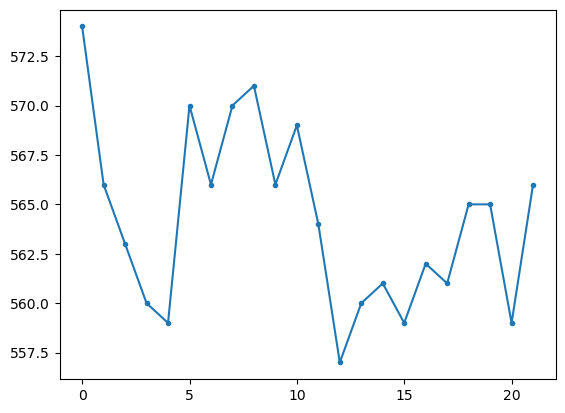

In [78]:
plt.plot([sp[1].data[1201] for sp in C.spectra],'.-')
#plt.plot([sp[2].data[1202] for sp in C.spectra])
#plt.plot([sp[0].data[1203] for sp in C.spectra])

13+(22-13)*25/len(C.spectra)

[sp[1].data[1201] for sp in C.spectra],


Text(0, 0.5, 'Relative drift [ppm]')

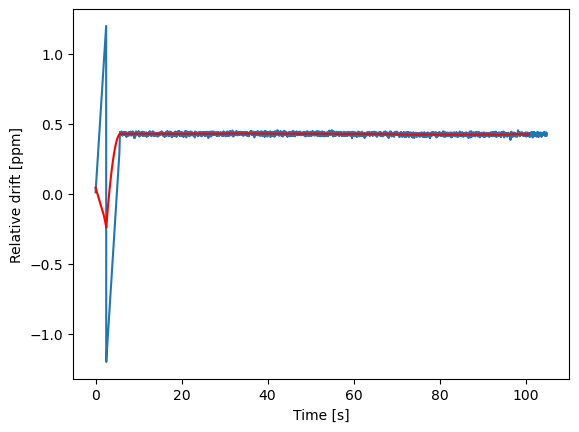

In [79]:
time = np.arange(len(C.cd_drift))*32*16*4096/102.4e6
plt.plot(time,C.cd_drift/alpha_to_pdrift)
avg_drift = np.convolve(C.cd_drift/alpha_to_pdrift, np.ones(200)/200, mode='valid')
avg_time = time[:len(avg_drift)]
plt.plot(avg_time, avg_drift,'r-')
plt.xlabel('Time [s]')  
plt.ylabel('Relative drift [ppm]')
#plt.xlim(0,1)
#plt.plot(Cd.cd_drift[:125]/alpha_to_pdrift)



In [80]:
(C.cd_drift/alpha_to_pdrift)[-5000:].std()/np.sqrt(5000)

np.float64(0.0023942724997918427)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  87.,  12.,  12.,  14.,  23.,  15.,  24.,  21.,  32.,  33.,
         32.,  35.,  35.,  39.,  40.,  48.,  51.,  50.,  58.,  73.,  52.,
         81.,  78.,  73.,  72.,  75.,  85.,  91.,  68.,  90.,  96., 107.,
        115., 116.,  93.,  98., 114., 114., 101., 116., 112.,  96., 111.,
         97., 115., 111.,  97., 104., 103.,  92.,  82.,  80.,  78.,  73.,
         59., 148.,  69.,  73.,  52.,  61.,  54.,  48.,  45.,  34.,  35.,
         31.,  28.,  25.,  26.,  17.,  23.,  13.,  19.,  17.,  21.,  11.,
         90.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([-2000.        , -1960.3960396 , -1920.79207921, -1881.18811881,
        -1841.58415842, -1801.98019802, -1762.37623762, -1722.77227723,
        -1683.16831683, -1643.56435644, -1603.96039604, -1564.35643564,
        -1524.75247525, -1485.14851485, -1445.54455446, -1405.94059406,
        -1366.33663366, 

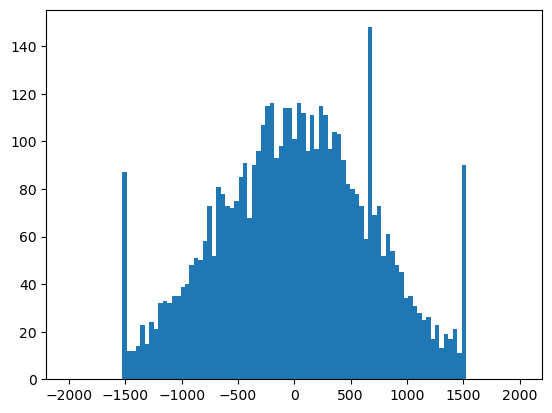

In [81]:
x = C.cd_drift[200:]/np.pi*(1<<30)#/alpha_to_pdrift
d = x[1:]-x[:-1]

plt.hist(d,bins=101,range=(-2000,+2000))
#plt.ylim(0,200)


Text(0.5, 0.98, 'PTOPBOT')

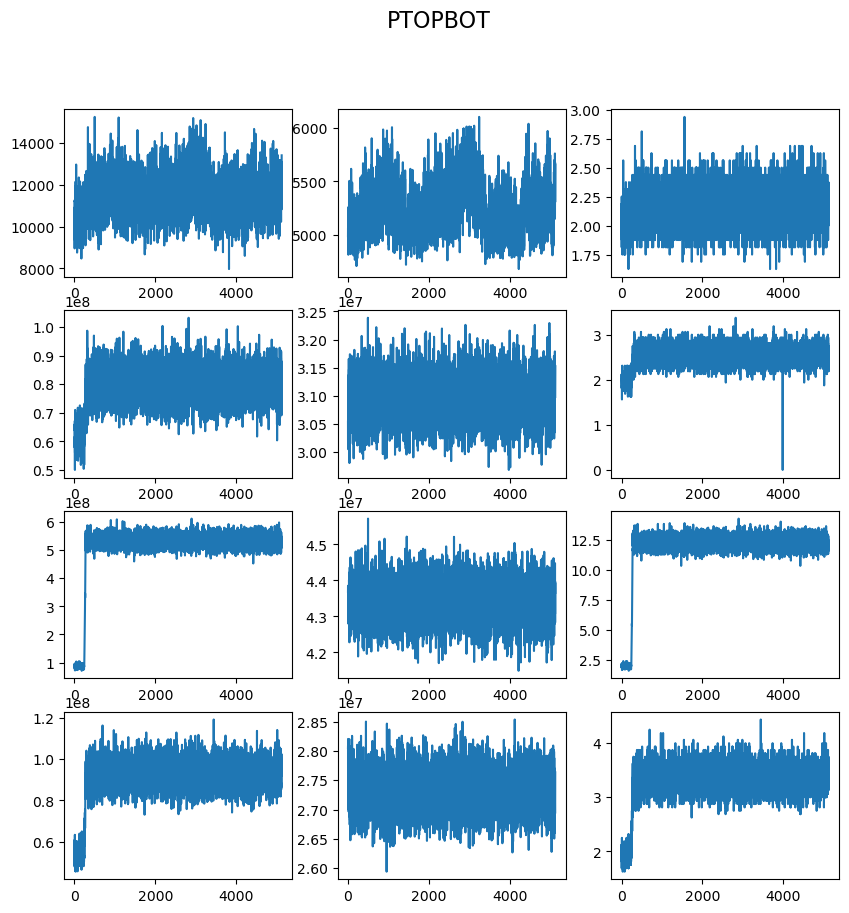

In [82]:
fig, ax = plt.subplots(4,3,figsize=(10,10))
ax[0,0].plot(C.cd_powertop0)
ax[1,0].plot(C.cd_powertop1)
ax[2,0].plot(C.cd_powertop2)
ax[3,0].plot(C.cd_powertop3)

ax[0,1].plot(C.cd_powerbot0)
ax[1,1].plot(C.cd_powerbot1)
ax[2,1].plot(C.cd_powerbot2)
ax[3,1].plot(C.cd_powerbot3)

ax[0,2].plot(C.cd_snr0)
ax[1,2].plot(C.cd_snr1)
ax[2,2].plot(C.cd_snr2)
ax[3,2].plot(C.cd_snr3)
fig.suptitle('PTOPBOT', fontsize=16)


(np.float64(6620912.546381401),
 np.float64(-1146782.6504237289),
 np.float64(79097621.85234375),
 np.float64(30962769.37714844))

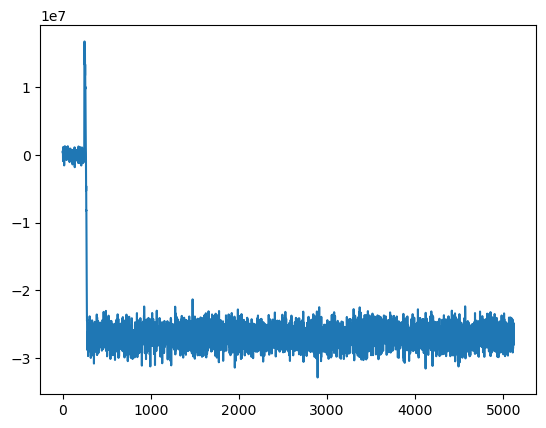

In [83]:
#plt.plot (C.cd_sd2[200:])
plt.plot (C.cd_sd2[:])
C.cd_fd1[400:].std(),C.cd_sd1[400:].mean(), C.cd_powertop1.mean(), C.cd_powerbot1.mean()
#plt.plot (C.cd_snr3[200:])
#plt.plot(C.cd_powerbot3)

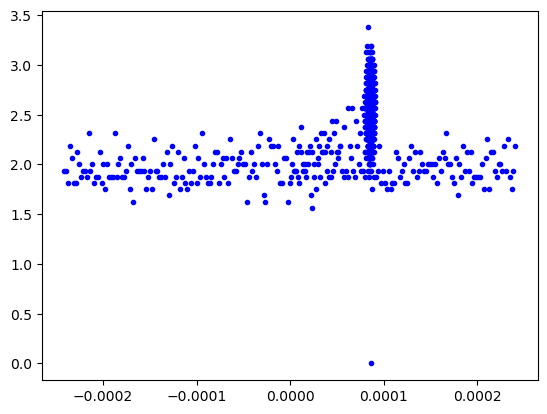

In [84]:
plt.plot(C.cd_drift,C.cd_snr1,'b.')
#C.cd_powerbot2[:4000].std()/C.cd_powerbot2[:4000].mean()
#Cd.cd_powertop2[1000:3000].mean()/C.cd_powertop2[1000:3000].mean()

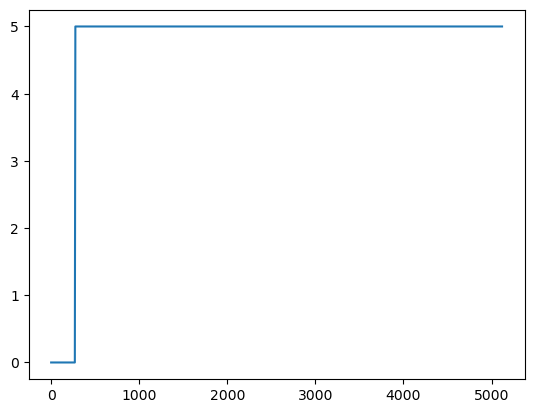

In [85]:
plt.plot(C.cd_have_lock)

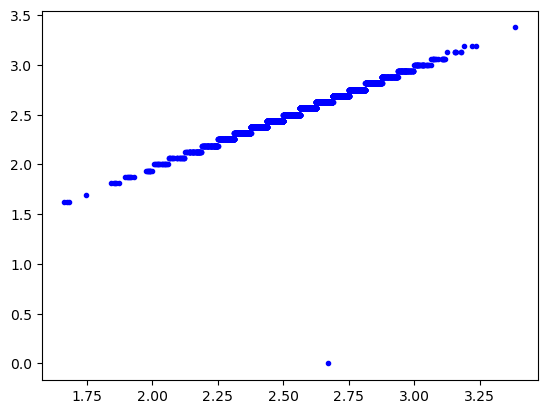

In [86]:
#plt.plot(Cd.cd_snr1[200:])
plt.plot(C.cd_powertop1[200:]/C.cd_powerbot1[200:], C.cd_snr1[200:],'b.')
#plt.plot()


#plt.plot(C.cd_fd2[1200:])
#plt.plot(C.cd_fd3[1200:])


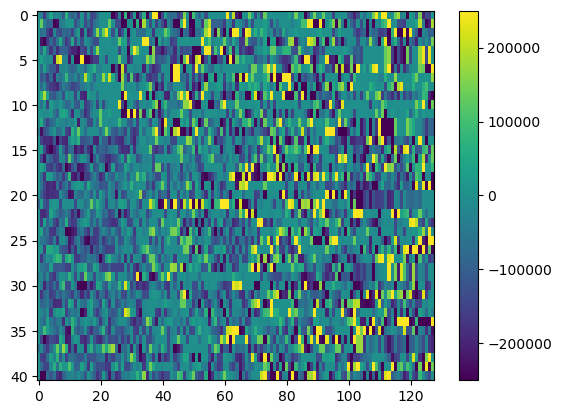

In [87]:
plt.imshow(C.calib_gphase[0:,:128],aspect='auto', interpolation='nearest')#,vmin=-100000, vmax=100000)
plt.colorbar()

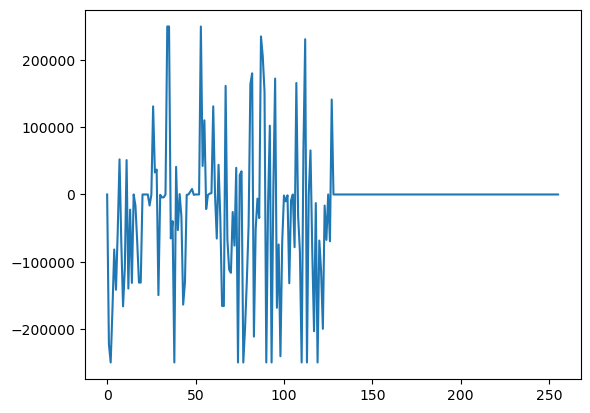

In [88]:
plt.plot(C.calib_gphase[3,:256])

[]

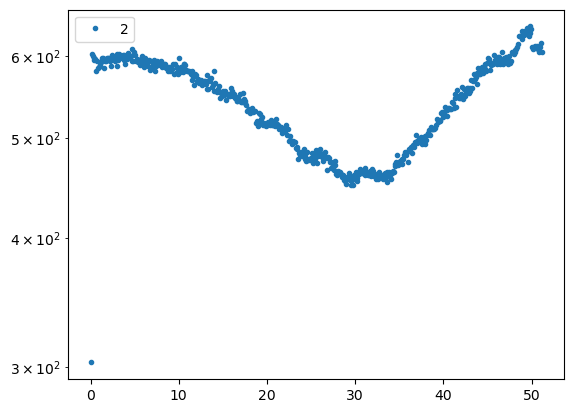

In [89]:
f = C.spectra[0][0].frequency
s0 = C.spectra[0][3].data[:]
s1 = C.spectra[1][3].data[:]
s2 = C.spectra[2][3].data[:]
#plt.plot(f,s2)
for i in [2]:
    plt.plot(f[i::4], s2[i::4],'.', label=str(i))
plt.legend()
#plt.plot(s1,'g.')
#plt.plot(s2,'b.')
#plt.plot(s1*0.001,'r.')

plt.semilogy()

Text(0, 0.5, 'power')

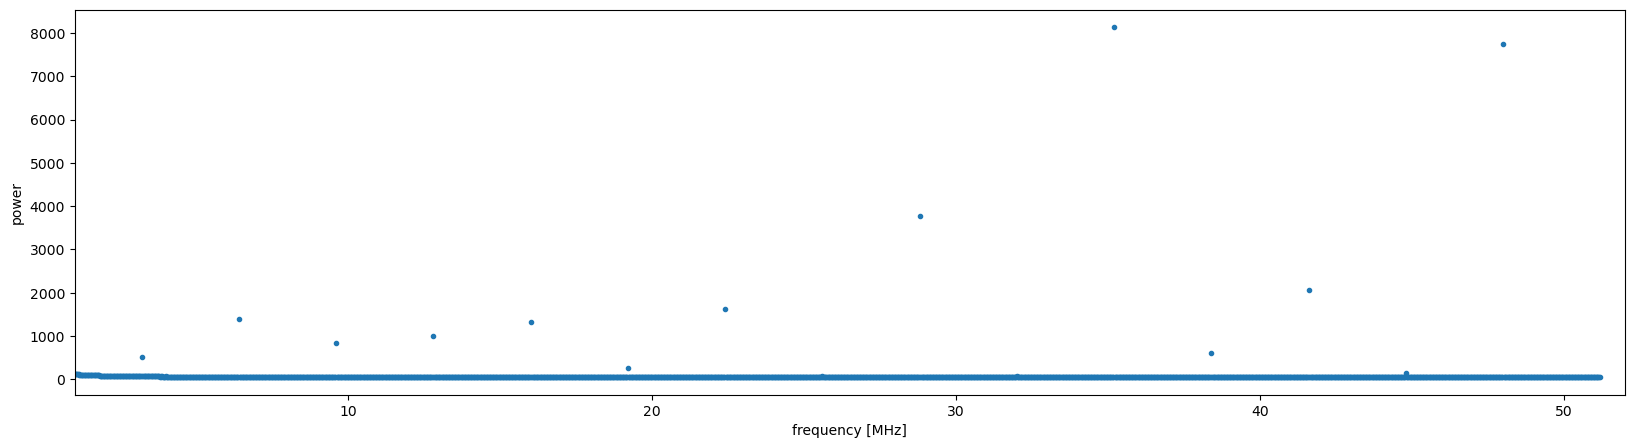

In [90]:

plt.figure(figsize=(20,5))
f = C.spectra[0][0].frequency
for i in [0]:
    s = np.mean([sp[i].data[:] for sp in C.spectra],axis=0)
    plt.plot(f[10:],s[10:],'.')

#plt.plot(f[2::4],s[2::4],'r.',markersize=3)
plt.xlim(1,52)
#plt.ylim(0,1e4)
#plt.ylim(3.0e6,5e6)
#plt.ylim(0.1e3,2e6)
#plt.ylim(3e6,2e7)
#plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

Text(0, 0.5, 'power')

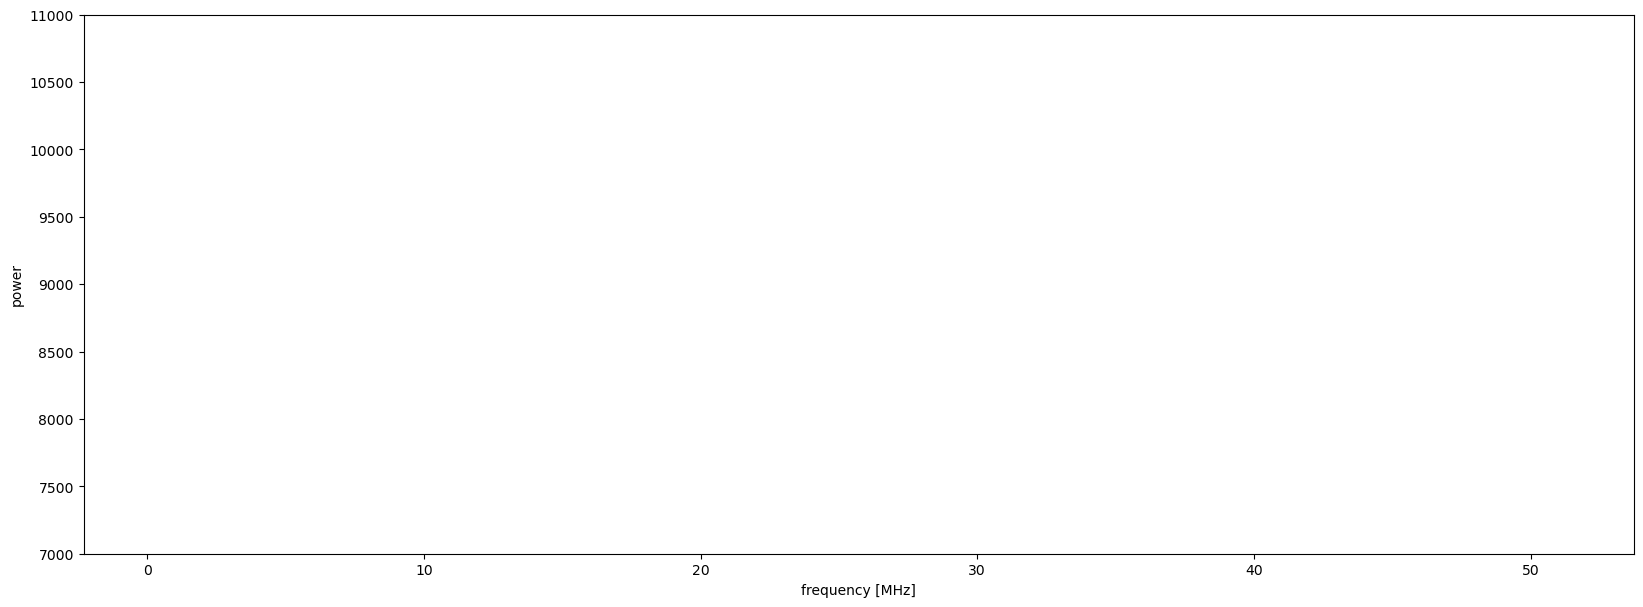

In [91]:

plt.figure(figsize=(20,7))
f = C.spectra[0][0].frequency
s = np.mean([sp[1].data[:] for sp in C.spectra],axis=0)
plt.plot(f[10:],s[10:],'b-')
#plt.plot(f,s*1.03,'k-')
plt.plot(f[10:2048:4],s[10:2048:4],'r-',markersize=3)

#plt.ylim(6e2,2e3)
#plt.xlim(38,52)
#plt.semilogy()
plt.ylim(7000,11e3)
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

Text(0, 0.5, 'power')

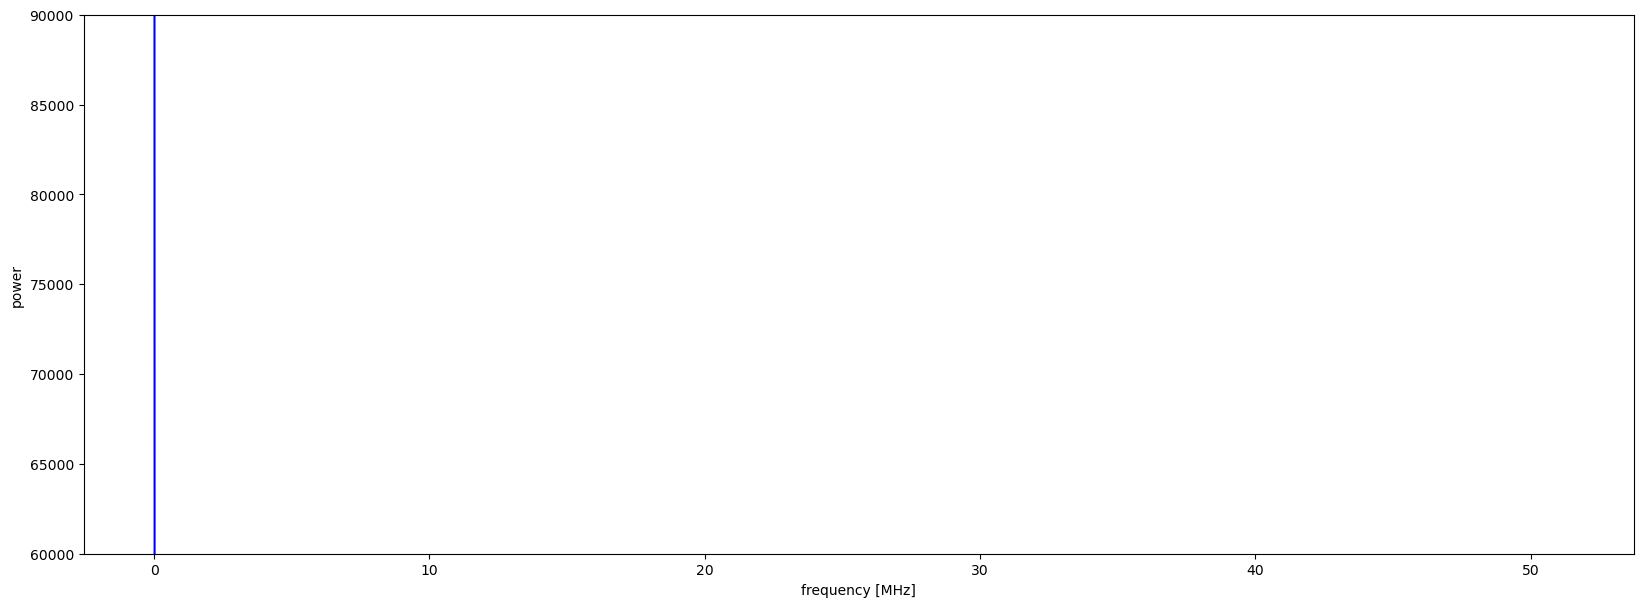

In [92]:
plt.figure(figsize=(20,7))
f = C.spectra[0][0].frequency
s = np.mean([sp[1].data[:] for sp in C.spectra],axis=0)
plt.plot(f,s,'b-')
#plt.plot(f,s*1.03,'k-')
plt.plot(f[2:2048:4],s[2:2048:4],'ro',markersize=3)

plt.ylim(60e3,90e3)



#plt.xlim(38,52)
#plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

In [93]:
kcomb = np.arange(512)*4+2

def phase_up (first, second):
    """ Phases up second waveform to the first one """
    Nfft= len(first)*1024
    cross= first*np.conj(second)
    fi = np.zeros(Nfft,complex)
    fi[kcomb] = cross
    xi = np.real(np.fft.fft(fi))
    phi = xi.argmax()*2*np.pi/len(xi)
    second_phased = np.exp(+1j*phi*kcomb)*second
    return second_phased
    

In [94]:
_,wf = np.loadtxt("calibrator_231001.txt").T
wf = np.fft.rfft(np.hstack((wf,wf)))
wf = wf[2::4]

In [95]:


def coherent_addition (C):
    calib_data = []
    for ch in range(4):
        first = np.copy(C.calib_data[-1,ch,:])
        for second in C.calib_data[-1:1:-1,ch,:]:
            second_phased = phase_up(first,second)
            first += second_phased
            #plt.plot(np.angle(first[20:]/second_phased[20:]))
            #plt.plot(second_phased[20:])
            #stop()
        calib_data.append(first)
    calib_data = np.array(calib_data)
    calib_data_wf = []
    for ch in range(4):
        first = np.zeros(512,dtype=complex)
        for second in C.calib_data[1:,ch,:]:
            second_phased = phase_up(wf,second)
            first += second_phased
            #plt.plot(np.angle(first[20:]/second_phased[20:]))
            #plt.plot(second_phased[20:])
            #stop()
        calib_data_wf.append(first)
    calib_data_wf = np.array(calib_data_wf)
    return calib_data, calib_data_wf

calib_data, calib_data_wf = coherent_addition(C)
#calib_datad, calib_data_wfd = coherent_addition(Cd)


(0.0, 510.0)

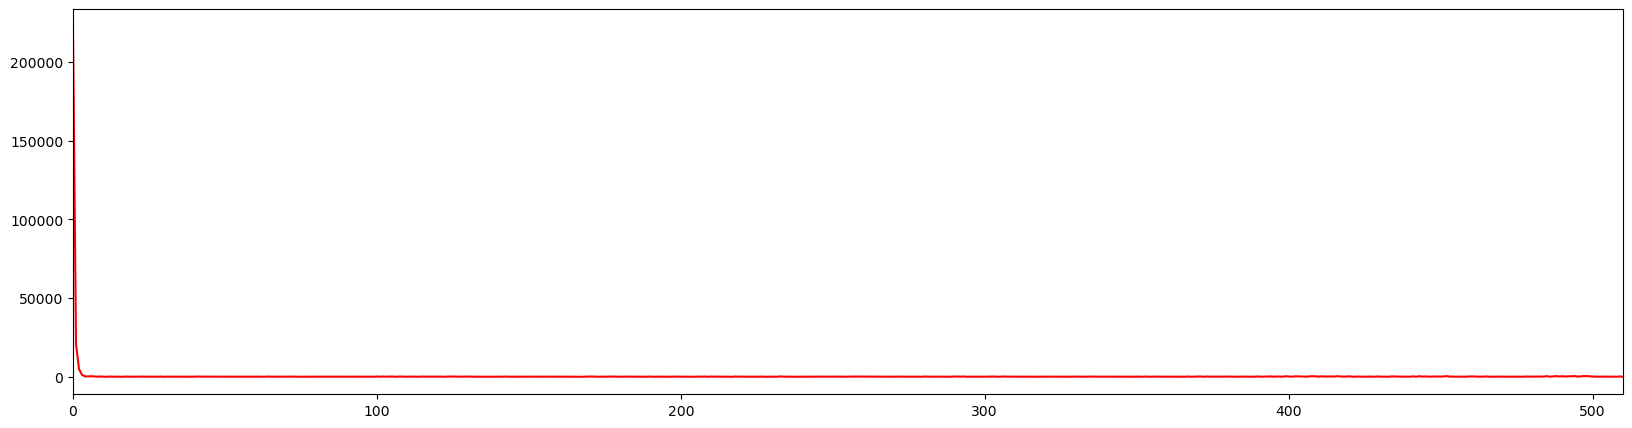

In [101]:
plt.figure(figsize=(20,5))
p1 = np.abs(calib_data[1,:])
#p2 = np.abs(calib_datad[3,30:])
            
#plt.plot((p1-p2)/p1)
#plt.ylim(-0.01,0.01)

#plt.plot(np.abs(calib_data_wf[1,:]),'b-')
plt.plot(np.abs(calib_data[0,:]),'r-')

plt.xlim(000,510)
#plt.plot(p2)


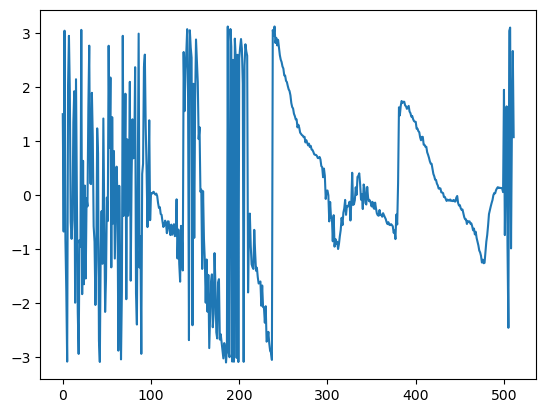

In [102]:
#plt.plot(np.abs(calib_data[2,30:]))
plt.plot(np.angle(calib_data_wf[2,:]*np.conj(calib_data_wf[3,:])))

[]

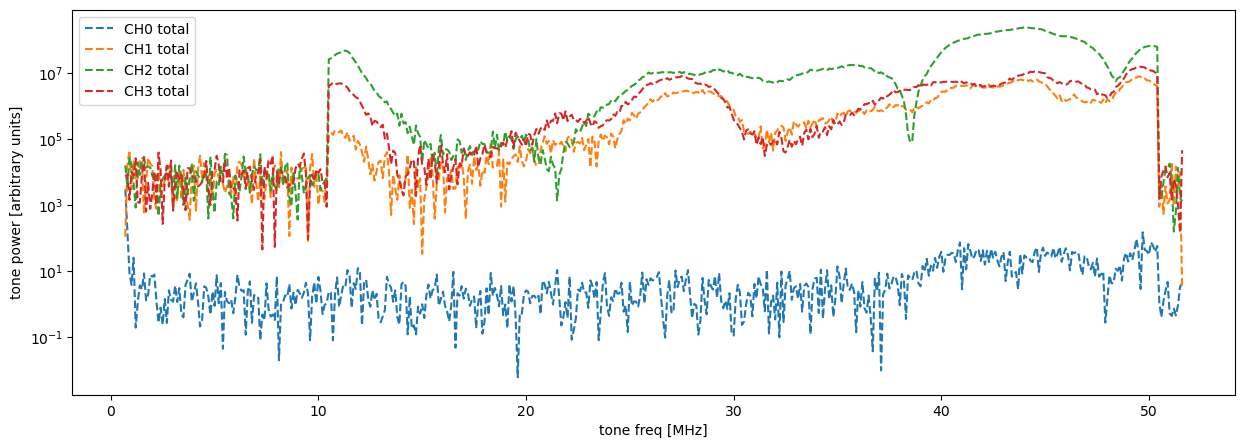

In [103]:
plt.figure(figsize=(15,5))
tfreq=0.5+0.1*np.arange(512)
for ch in [0,1,2,3]:#range(0,4):
    #plt.plot(tfreq[2:],np.abs(C.calib_data[1:,ch,2:]**2).mean(axis=0),label='CH'+str(ch)+" one int period")
    da = np.abs(calib_data_wf[ch,2:]**2)
    plt.plot(tfreq[2:],da/3000,ls='--',label='CH'+str(ch)+" total")
    #plt.plot(tfreq[2:],np.abs(Cd.calib_data[0:1,ch,2:]**2).mean(axis=0)*4,label='CH'+str(ch))
    #plt.plot(np.abs(Cx.calib_data[ch,1:,:]**1).mean(axis=0), label='CH'+str(ch))

    #plt.plot(np.abs(C.calib_data[ch,1:,100:500]**1).mean(axis=0)/np.abs(Cx.calib_data[ch,1:,100:500]**1).mean(axis=0), label='CH'+str(ch))


plt.legend()
plt.xlabel('tone freq [MHz]')
plt.ylabel('tone power [arbitrary units]')

#i1= np.real(C.calib_data[2,:,400])
#i2=np.imag(C.calib_data[2,:,400])
#i3= np.real(C.calib_data[3,:,400])
#plt.plot(np.imag(C.calib_data[3,:,100]))
#plt.plot(C.calib_data[0,:,400])
#plt.plot(r3**2+i3**2)

plt.semilogy()


In [104]:
#ch = 2
plt.figure(figsize=(20,5))
for i in range(4):
    s = np.mean([sp[ch].data[:] for sp in C.spectra],axis=0)[i::4]
    #c = np.abs(C.calib_data[:,ch,:]**2).mean(axis=0)
    fac = s[400]/c[400]*0.25
    
    plt.plot(s,'.')
    #plt.plot(c*fac,'.c-')
    plt.xlabel('frequency [MHz]')
    plt.ylabel('power [arbitrary units]')
    plt.semilogy()

NameError: name 'c' is not defined

<Figure size 2000x500 with 0 Axes>

In [105]:
np.abs(C.calib_data[1:,0,0:])


array([[5.54057199e+03, 5.46635162e+02, 1.28798292e+02, ...,
        9.48683298e+00, 2.82842712e+00, 1.20415946e+01],
       [5.49581086e+03, 5.21943484e+02, 1.31487642e+02, ...,
        9.00000000e+00, 1.14017543e+01, 8.60232527e+00],
       [5.50984437e+03, 5.34132942e+02, 1.29073622e+02, ...,
        5.00000000e+00, 2.61725047e+01, 1.10453610e+01],
       ...,
       [5.65737077e+03, 4.81433277e+02, 1.22690668e+02, ...,
        1.08166538e+01, 9.84885780e+00, 4.24264069e+00],
       [5.57702752e+03, 5.30495052e+02, 1.39445330e+02, ...,
        4.24264069e+00, 1.00498756e+01, 9.00000000e+00],
       [5.52074361e+03, 5.40937150e+02, 1.11503363e+02, ...,
        1.34536240e+01, 1.48660687e+01, 9.84885780e+00]], shape=(40, 512))

Text(0, 0.5, 'time index')

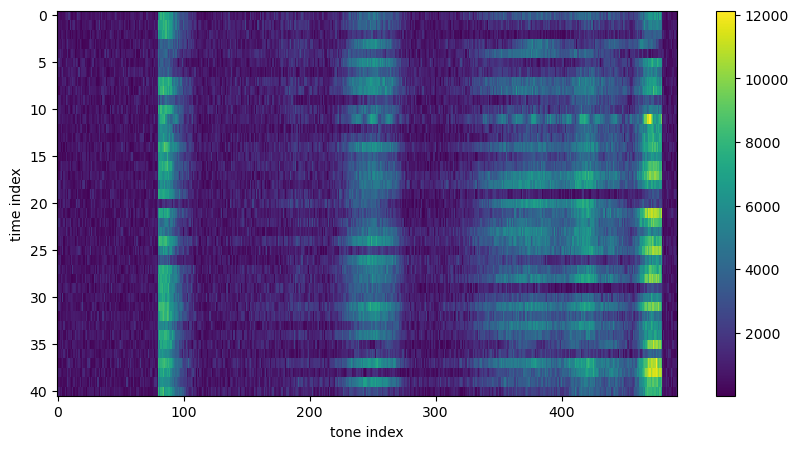

In [113]:
ch=3
plt.figure(figsize=(10,5))
plt.imshow(np.abs(C.calib_data[0:,ch,20:]),aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('tone index')
plt.ylabel('time index')

Text(0.5, 0, 'time index')

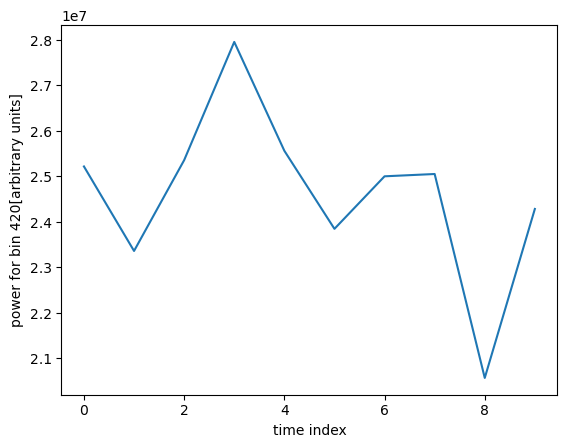

In [225]:
plt.plot(np.abs(C.calib_data[1:,ch,420]**2))
plt.ylabel('power for bin 420[arbitrary units]')
plt.xlabel('time index')

In [63]:
pcalib = phase_up(wf,calib_data_wf[2,:])
wf.shape, calib_data_wf[2,:].shape

((512,), (512,))

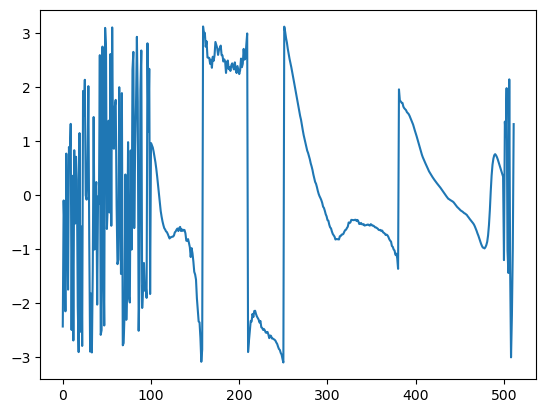

In [42]:
#plt.plot(np.angle(calib_data[1,:]/wf))
plt.plot(np.angle(pcalib/wf))

#plt.plot(np.imag(pcalib/wf))

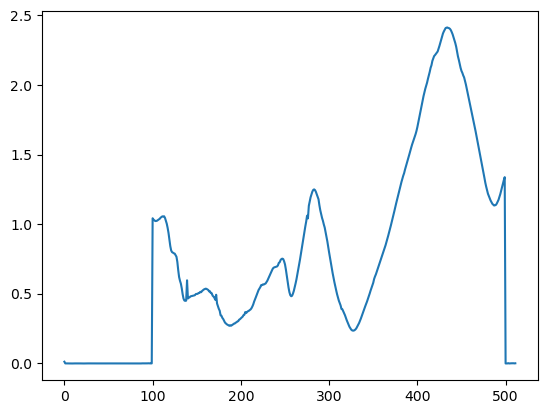

In [1206]:
plt.plot(np.abs(pcalib/wf))

In [79]:
ch=2 
print (C.calib_data[15,ch,:].shape)
pcalib = phase_up(C.calib_data[15,ch,:], C.calib_data[25,ch,:])


(512,)


In [85]:
M = C.spectra[1]['meta']
M.base.actual_gain[:],M.base.gain[:], M.adc_max

([2, 2, 2, 2], [2, 2, 2, 2], array([ -16, 1088, 1122, 1684]))

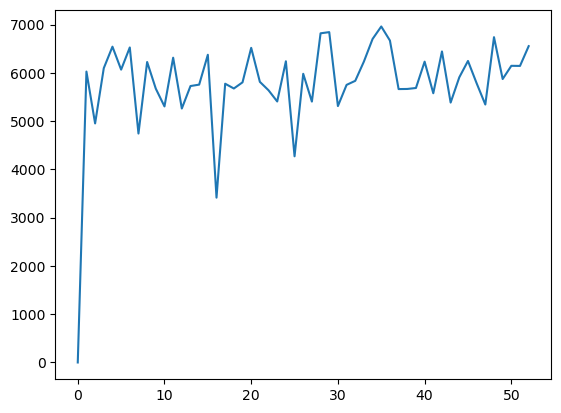

In [80]:
plt.plot(np.abs(C.calib_data[0:,ch,300]))